In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from icevision.all import *

In [3]:
model_type = models.mmdet.mask_rcnn

In [4]:
data_dir = icedata.pennfudan.load_data()
parser = icedata.pennfudan.parser(data_dir)

In [5]:
train_records, valid_records = parser.parse(autofix=False)

  0%|          | 0/170 [00:00<?, ?it/s]

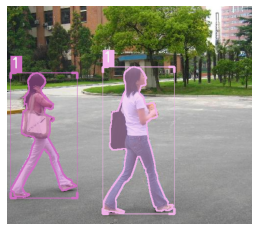

In [6]:
show_record(train_records[0], show=True)

In [7]:
presize, size = 256, 128
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(presize=presize, size=size), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

In [8]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [9]:
train_dl = model_type.train_dl(train_ds, batch_size=2, num_workers=0, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=2, num_workers=0, shuffle=False)

In [10]:
batch, samples = first(train_dl)

In [11]:
cfg = "~/git/mmdetection/configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py"

In [12]:
model = model_type.model(cfg, num_classes=len(parser.class_map))

2021-01-26 18:54:18,060 - mmdet - INFO - load model from: torchvision://resnet50
2021-01-26 18:54:18,734 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



In [13]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, splitter=fastai.trainable_params)

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=9.999999747378752e-06)

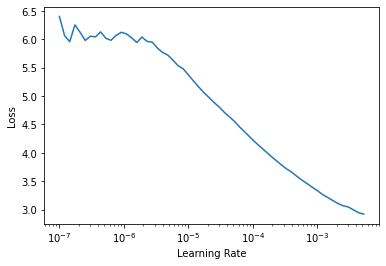

In [14]:
learn.lr_find()

In [19]:
learn.fine_tune(2, 1e-3)

epoch,train_loss,valid_loss,time
0,1.314950,0.971581,00:20


epoch,train_loss,valid_loss,time
0,0.920289,0.842862,00:21
1,0.806542,0.624093,00:20


In [21]:
learn.__class__

fastai.learner.Learner

In [20]:
learn.save('mmdet_mask_test')

/home/lgvaz/miniconda3/envs/mmlab/lib/python3.7/site-packages/fastai/callback/core.py:50: UserWarning: You are setting an attribute (__class__) that also exists in the learner, so you're not setting it in the learner but in the callback. Use `self.learn.__class__` otherwise.
  warn(f"You are setting an attribute ({name}) that also exists in the learner, so you're not setting it in the learner but in the callback. Use `self.learn.{name}` otherwise.")


Path('models/mmdet_mask_test.pth')

In [22]:
learn.load('mmdet_mask_test')

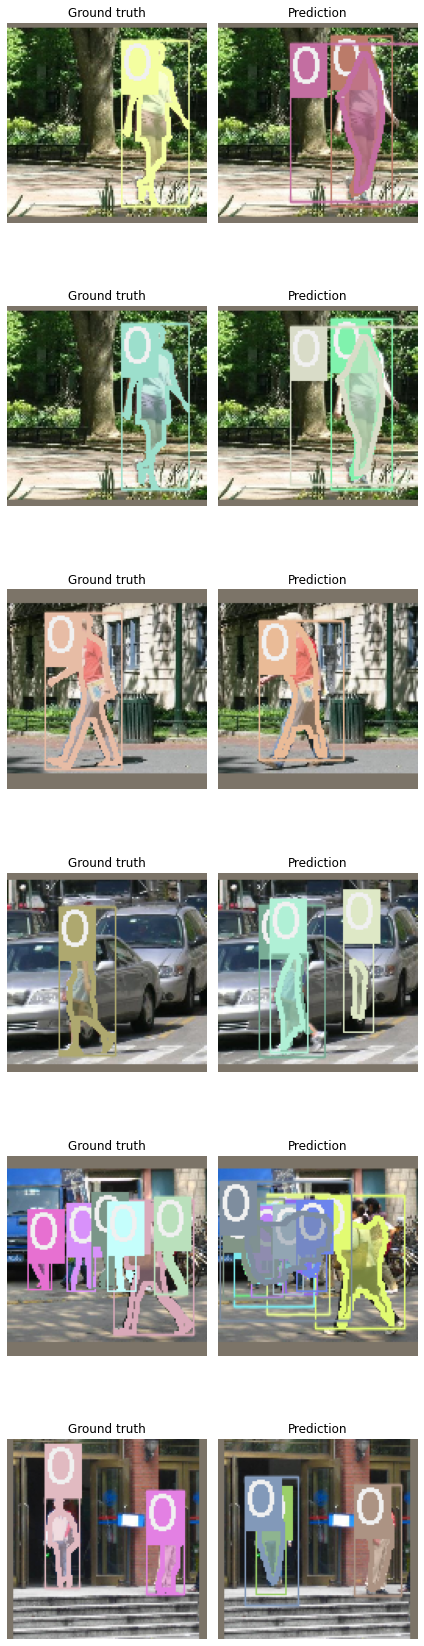

In [23]:
model = model.eval().cuda()
model_type.show_results(model, valid_ds)

In [17]:
# model = model.eval().cpu()
model = model.eval().cuda()
infer_dl = model_type.infer_dl(valid_ds, batch_size=1, shuffle=False)

In [18]:
batch, samples = first(infer_dl)

In [21]:
pred = model_type.predict(model, batch)

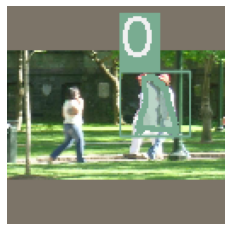

In [23]:
show_pred(samples[0]['img'], pred)